**Просимулировал линрег/логрег с непрерывным фактором, вместо бинарного**

**Суть**: разница в пвалью появляется, если подставить распредление Фишера

Про разницу:
- Во первых, в случае с бинарным факторов пвалью не одинаковые, они начинают различаться на 5й-6й знак после запятой
    - линрег только в 25% случаях имел более низкий пвалью (это я к тому, что различие вряд ли случайны и вызваны округлениями пайтона внутренними к примеру)

- при переходе с бинарного фактора на непрерывный с нормальным распределением, pvalue у линрега и логрега практическине различаются (5й-6й знак только)
- при переходе с бинарного фактора на непрерывный с распределением фишера, pvalue у линрега и логрега сильно различаются
    - при этом логрег чувствительнее (приложил фотку, на которой прогнал в цикле две модели и посчитал, сколько в среднем та или иная модель обнаруживала различия)

Почему тут такое различие в зависимости от вида распределения, я не очень пока понял

Кстати распределение Фишера это просто частный случай распределения Вэйбулла

In [5]:
import numpy as np
import pandas as pd
from statsmodels.stats.weightstats import ttest_ind
from statsmodels.regression.linear_model import OLS
from statsmodels.discrete.discrete_model import Logit
from statsmodels.api import add_constant
from scipy.stats import t as t_critical

# visualisation
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()
%config InlineBackend.figure_format = 'retina'

In [6]:
def get_mde(array, alpha=0.05, power=0.8):

    avg = np.mean(array)
    std = np.std(array)
    se = std / np.sqrt(array.shape[0])

    two_sided_alpha = 1 - alpha / 2
    # что это? зачем так делать? вместо power нужен 0.025?
    M = t_critical.ppf(two_sided_alpha, size) + t_critical.ppf(power, size) 

    mde = np.round(M * se / avg, 4)
    relative_mde = str(np.round(100 * mde / avg, 2)) + '%'

    return mde, relative_mde

## Binary factor

In [284]:
def get_results_for_bernoulli(p, coeff, size=10000):
    control = np.random.binomial(1, p, size)
    test = np.random.binomial(1, p * coeff, size)

    Y = np.concatenate((control, test))
    X = np.array([0] * size + [1] * size)
    X = add_constant(X)
    
    lin = OLS(Y, X).fit()
    log = Logit(Y, X).fit()

    print('____________________________________linreg____________________________________')
    print(lin.summary().tables[1])
    print('\n')
    print('____________________________________logreg____________________________________')
    print(log.summary().tables[1])
    
    print('p1 = ' + str(lin.pvalues[1]) + ', p2 = ' + str(log.pvalues[1]))
    print('LIN' if lin.pvalues[1] < log.pvalues[1] else 'LOG')
    return 1 if lin.pvalues[1] < log.pvalues[1] else 0

In [289]:
def get_results_for_bernoulli_(p, coeff, size=10000):
    control = np.random.binomial(1, p, size)
    test = np.random.binomial(1, p * coeff, size)

    Y = np.concatenate((control, test))
    X = np.array([0] * size + [1] * size)
    X = add_constant(X)
    
    lin = OLS(Y, X).fit()
    log = Logit(Y, X).fit()

    return 1 if lin.pvalues[1] < log.pvalues[1] else 0

In [278]:
t = get_results_for_bernoulli(0.63, 1.01)

Optimization terminated successfully.
         Current function value: 0.656745
         Iterations 4
____________________________________linreg____________________________________
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6270      0.005    130.161      0.000       0.618       0.636
x1             0.0138      0.007      2.026      0.043       0.000       0.027


____________________________________logreg____________________________________
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5194      0.021     25.117      0.000       0.479       0.560
x1             0.0595      0.029      2.026      0.043       0.002       0.117
p1 = 0.04280804408588312, p2 = 0.04281501636487721
LIN


In [291]:
arr = []
for i in range(100):
    arr.append(get_results_for_bernoulli_(0.63, 1.01))
np.mean(arr)

Optimization terminated successfully.
         Current function value: 0.656613
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.664234
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.656599
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.653645
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.658849
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.658240
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.657928
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.655441
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.656276
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.659280
  

0.25

**resume**: У линрега и логрега одинаковая чувствительность и fpr, если таргет бинарный, и фактор тоже бинарный  
  
**гипотеза**: это потому что если фактор бинарный, то мы берем концы функции только (0 и 1), нам не надо апроксимировать линией непрерывный фактор => не важно у тебя будет сигмоида или линия  
Согласно этой гипотезе, при непрерывном факторе должны уже быть разные чувствительности и fpr'ы

## Continious factor

### fisher

###### Как выглядит фактор, c распределением фишера

[(0.0, 10.0)]

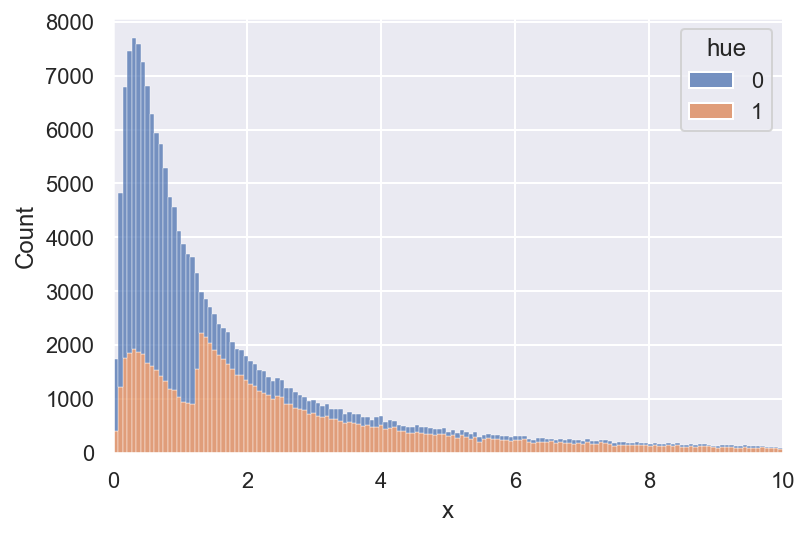

In [329]:
size = 100000

control = np.random.binomial(1, 0.25, size)
test = np.random.binomial(1, 0.75, size)
Y = np.append(control, test)

x_sample = sorted(np.random.f(5, 2, size*2))
X = x_sample
data = pd.DataFrame({'x':X, 'hue':Y})

(
    sns.histplot(data = data.query('x < 10'), x = 'x', hue = 'hue', multiple='stack')
    .set(xlim = (0, 10))
)

In [524]:
def get_results_for_continious_factor_fisher(p1, p2, size=10000):
    control = np.random.binomial(1, p1, size)
    test = np.random.binomial(1, p2, size)
    Y = np.concatenate((control, test))
    
    x_sample = sorted(np.random.f(5, 2, size*2))
    X = np.array(x_sample)
    X = add_constant(X)
    
    lin = OLS(Y, X).fit()
    log = Logit(Y, X).fit()

    print('____________________________________linreg____________________________________')
    print(lin.summary().tables[1])
    print('\n')
    print('____________________________________logreg____________________________________')
    print(log.summary().tables[1])
    
    print('lin_pvalue = ' + str(lin.pvalues[1]) + ', log_pvalue = ' + str(log.pvalues[1]))
    
    
    return 1 if lin.pvalues[1] < 0.05 else 0, 1 if log.pvalues[1] < 0.05 else 0

In [528]:
lin, log = get_results_for_continious_factor_fisher(0.7, 0.9)

Optimization terminated successfully.
         Current function value: 0.500262
         Iterations 10
____________________________________linreg____________________________________
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7995      0.003    282.325      0.000       0.794       0.805
x1            6.3e-06   5.44e-06      1.159      0.247   -4.36e-06     1.7e-05


____________________________________logreg____________________________________
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.3607      0.018     74.259      0.000       1.325       1.397
x1             0.0041      0.001      3.914      0.000       0.002       0.006
lin_pvalue = 0.24660727488521553, log_pvalue = 9.059647745923835e-05


In [537]:
df = pd.DataFrame({'is_detect':[], 'model':[]})

n = 100
for i in range(100):
    lin, log = get_results_for_continious_factor_fisher(0.7, 0.9)
    df = df.append({'is_detect':lin, 'model':'lin'}, ignore_index=True)
    df = df.append({'is_detect':log, 'model':'log'}, ignore_index=True)

Optimization terminated successfully.
         Current function value: 0.497348
         Iterations 7
____________________________________linreg____________________________________
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8020      0.003    284.396      0.000       0.796       0.808
x1           1.42e-05   1.17e-05      1.209      0.227   -8.83e-06    3.72e-05


____________________________________logreg____________________________________
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.3978      0.018     78.409      0.000       1.363       1.433
x1             0.0002      0.000      0.987      0.324      -0.000       0.001
lin_pvalue = 0.22686210074469146, log_pvalue = 0.3235249880679111
Optimization terminated successfully.
  

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.3633      0.019     73.621      0.000       1.327       1.400
x1             0.0055      0.001      4.571      0.000       0.003       0.008
lin_pvalue = 0.12916513070010482, log_pvalue = 4.8430007621070566e-06
Optimization terminated successfully.
         Current function value: 0.497884
         Iterations 8
____________________________________linreg____________________________________
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8017      0.003    284.252      0.000       0.796       0.807
x1          6.133e-06   6.24e-06      0.982      0.326    -6.1e-06    1.84e-05


____________________________________logreg____________________________________
                 coef    std err    

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.3538      0.018     74.308      0.000       1.318       1.389
x1             0.0039      0.001      3.958      0.000       0.002       0.006
lin_pvalue = 0.3236322137472598, log_pvalue = 7.571173981769588e-05
Optimization terminated successfully.
         Current function value: 0.497233
         Iterations 8
____________________________________linreg____________________________________
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8000      0.003    282.439      0.000       0.794       0.806
x1          8.118e-05   2.67e-05      3.041      0.002    2.89e-05       0.000


____________________________________logreg____________________________________
                 coef    std err      

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7969      0.003    280.063      0.000       0.791       0.802
x1          2.736e-06   3.34e-06      0.819      0.413   -3.81e-06    9.28e-06


____________________________________logreg____________________________________
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.3561      0.018     75.574      0.000       1.321       1.391
x1             0.0017      0.001      2.575      0.010       0.000       0.003
lin_pvalue = 0.4127671545654613, log_pvalue = 0.01002486900653626
Optimization terminated successfully.
         Current function value: 0.500192
         Iterations 5
____________________________________linreg____________________________________
                 coef    std err        

Optimization terminated successfully.
         Current function value: 0.500190
         Iterations 9
____________________________________linreg____________________________________
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7981      0.003    280.838      0.000       0.792       0.804
x1          6.386e-05   2.11e-05      3.027      0.002    2.25e-05       0.000


____________________________________logreg____________________________________
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.3272      0.019     70.549      0.000       1.290       1.364
x1             0.0111      0.002      6.208      0.000       0.008       0.015
lin_pvalue = 0.002473943968704265, log_pvalue = 5.355012918438796e-10
Optimization terminated successfully

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.3367      0.019     71.943      0.000       1.300       1.373
x1             0.0076      0.001      5.264      0.000       0.005       0.010
lin_pvalue = 0.0975746476633198, log_pvalue = 1.4065443038547922e-07
Optimization terminated successfully.
         Current function value: 0.502112
         Iterations 8
____________________________________linreg____________________________________
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7967      0.003    279.232      0.000       0.791       0.802
x1             0.0001   3.49e-05      3.521      0.000    5.45e-05       0.000


____________________________________logreg____________________________________
                 coef    std err     

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7990      0.003    281.685      0.000       0.793       0.805
x1          2.603e-05   1.63e-05      1.600      0.110   -5.85e-06    5.79e-05


____________________________________logreg____________________________________
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.3726      0.018     76.308      0.000       1.337       1.408
x1             0.0014      0.001      2.276      0.023       0.000       0.003
lin_pvalue = 0.10954388484772248, log_pvalue = 0.022816812850366446
Optimization terminated successfully.
         Current function value: 0.497840
         Iterations 5
____________________________________linreg____________________________________
                 coef    std err      

Optimization terminated successfully.
         Current function value: 0.500249
         Iterations 8
____________________________________linreg____________________________________
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7995      0.003    282.018      0.000       0.794       0.805
x1           3.91e-05   1.79e-05      2.191      0.028    4.12e-06    7.41e-05


____________________________________logreg____________________________________
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.3771      0.018     76.683      0.000       1.342       1.412
x1             0.0012      0.001      2.255      0.024       0.000       0.002
lin_pvalue = 0.028491163065823725, log_pvalue = 0.024120601298825855
Optimization terminated successfully.

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.3610      0.018     74.602      0.000       1.325       1.397
x1             0.0034      0.001      3.543      0.000       0.002       0.005
lin_pvalue = 0.012875720851147373, log_pvalue = 0.00039622153387578824
Optimization terminated successfully.
         Current function value: 0.490065
         Iterations 14
____________________________________linreg____________________________________
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8041      0.003    286.537      0.000       0.799       0.810
x1          2.329e-07   4.07e-07      0.572      0.567   -5.65e-07    1.03e-06


____________________________________logreg____________________________________
                 coef    std err  

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.2919      0.018     70.597      0.000       1.256       1.328
x1             0.0075      0.001      5.416      0.000       0.005       0.010
lin_pvalue = 0.0358003565172714, log_pvalue = 6.110128865399688e-08
Optimization terminated successfully.
         Current function value: 0.501706
         Iterations 11
____________________________________linreg____________________________________
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7976      0.003    280.686      0.000       0.792       0.803
x1          1.672e-06   1.87e-06      0.892      0.372      -2e-06    5.35e-06


____________________________________logreg____________________________________
                 coef    std err     

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.3658      0.019     71.295      0.000       1.328       1.403
x1             0.0118      0.002      6.087      0.000       0.008       0.016
lin_pvalue = 0.03106610734213323, log_pvalue = 1.1500569616826063e-09
Optimization terminated successfully.
         Current function value: 0.499400
         Iterations 10
____________________________________linreg____________________________________
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7997      0.003    282.536      0.000       0.794       0.805
x1          7.554e-06   6.27e-06      1.205      0.228   -4.73e-06    1.98e-05


____________________________________logreg____________________________________
                 coef    std err   

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.3659      0.018     75.697      0.000       1.331       1.401
x1             0.0020      0.001      2.921      0.003       0.001       0.003
lin_pvalue = 0.3463933515464841, log_pvalue = 0.003492506448745312
Optimization terminated successfully.
         Current function value: 0.503905
         Iterations 9
____________________________________linreg____________________________________
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7974      0.003    280.478      0.000       0.792       0.803
x1          3.446e-06   4.08e-06      0.845      0.398   -4.55e-06    1.14e-05


____________________________________logreg____________________________________
                 coef    std err       

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.3254      0.018     73.366      0.000       1.290       1.361
x1             0.0033      0.001      3.352      0.001       0.001       0.005
lin_pvalue = 0.10011595651016052, log_pvalue = 0.0008015038335178763
Optimization terminated successfully.
         Current function value: 0.500788
         Iterations 6
____________________________________linreg____________________________________
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7995      0.003    281.736      0.000       0.794       0.805
x1          2.219e-05   2.26e-05      0.981      0.327   -2.21e-05    6.65e-05


____________________________________logreg____________________________________
                 coef    std err     

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8000      0.003    282.484      0.000       0.794       0.806
x1           7.06e-05   2.23e-05      3.162      0.002    2.68e-05       0.000


____________________________________logreg____________________________________
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.3335      0.019     70.064      0.000       1.296       1.371
x1             0.0128      0.002      6.493      0.000       0.009       0.017
lin_pvalue = 0.0015692915941842632, log_pvalue = 8.408978264956459e-11
Optimization terminated successfully.
         Current function value: 0.492144
         Iterations 11
____________________________________linreg____________________________________
                 coef    std err  

Optimization terminated successfully.
         Current function value: 0.496793
         Iterations 10
____________________________________linreg____________________________________
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8011      0.003    283.714      0.000       0.796       0.807
x1          1.275e-05   8.06e-06      1.582      0.114   -3.05e-06    2.86e-05


____________________________________logreg____________________________________
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.3423      0.019     70.619      0.000       1.305       1.380
x1             0.0118      0.002      6.109      0.000       0.008       0.016
lin_pvalue = 0.11362627086757374, log_pvalue = 1.00047316712511e-09


<AxesSubplot:xlabel='model', ylabel='is_detect'>

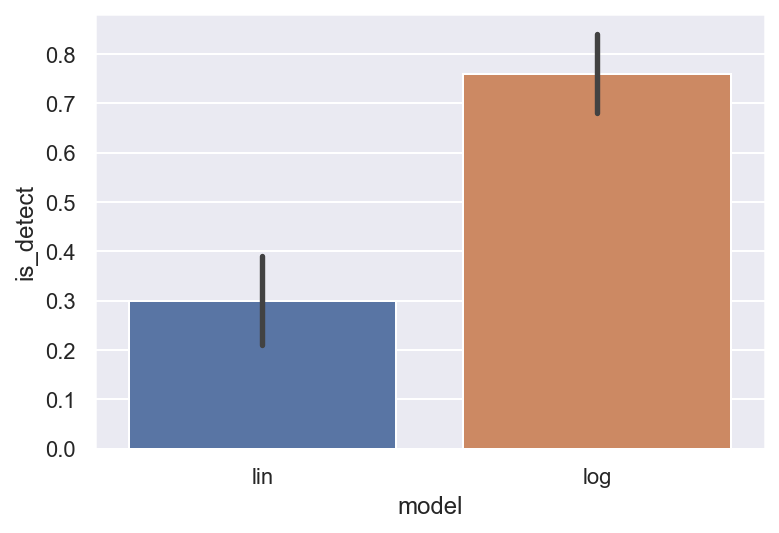

In [538]:
sns.barplot(x = df.model, y = df.is_detect)

### normal 2

[(0.0, 10.0)]

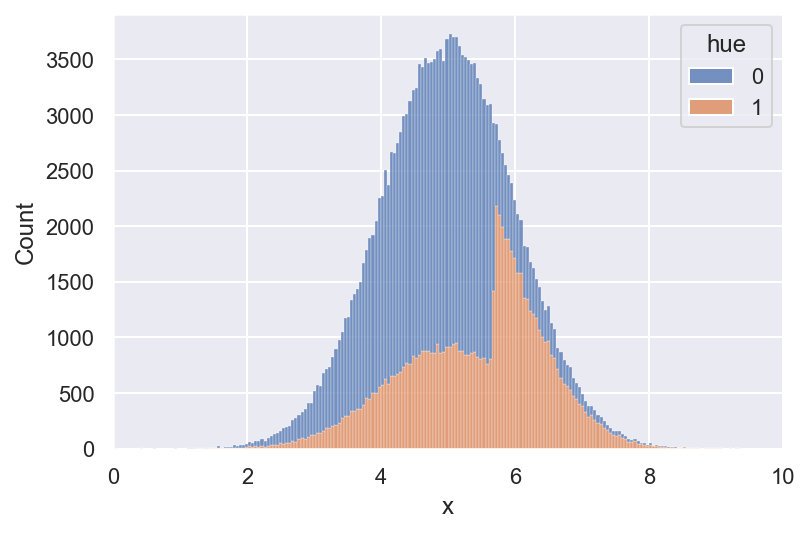

In [519]:
size = 100000

control = np.random.binomial(1, 0.25, int(size*1.5))
test = np.random.binomial(1, 0.75, int(size/2))
Y = np.append(control, test)

x_sample = sorted(np.random.normal(5, 1, size*2))
X = x_sample
data = pd.DataFrame({'x':X, 'hue':Y})

(
    sns.histplot(data = data.query('x < 10'), x = 'x', hue = 'hue', multiple='stack')
    .set(xlim = (0, 10))
)

In [464]:
def get_results_for_continious_factor_normal_2(p1, p2, size=10000):
    control = np.random.binomial(1, p1, int(size*1.5))
    test = np.random.binomial(1, p2, int(size/2))
    Y = np.concatenate((control, test))
    
    x_sample = sorted(np.random.normal(0, 1, size*2))
    X = np.array(x_sample)
    X = add_constant(X)
    
    lin = OLS(Y, X).fit()
    log = Logit(Y, X).fit()

    print('____________________________________linreg____________________________________')
    print(lin.summary().tables[1])
    print('\n')
    print('____________________________________logreg____________________________________')
    print(log.summary().tables[1])
    
    print('lin_pvalue = ' + str(lin.pvalues[1]) + ', log_pvalue = ' + str(log.pvalues[1]))
    print('LIN' if lin.pvalues[1] < log.pvalues[1] else 'LOG')
    return 'LIN' if lin.pvalues[1] < log.pvalues[1] else 'LOG'

In [518]:
get_results_for_continious_factor_normal_2(0.6, 0.7, size = 1000)

Optimization terminated successfully.
         Current function value: 0.660527
         Iterations 4
____________________________________linreg____________________________________
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6270      0.011     57.942      0.000       0.606       0.648
x1             0.0017      0.011      0.153      0.878      -0.020       0.023


____________________________________logreg____________________________________
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5193      0.046     11.229      0.000       0.429       0.610
x1             0.0071      0.046      0.153      0.878      -0.084       0.098
lin_pvalue = 0.8783100043681613, log_pvalue = 0.8782355523949198
LOG


'LOG'

### normal

[(0.0, 10.0)]

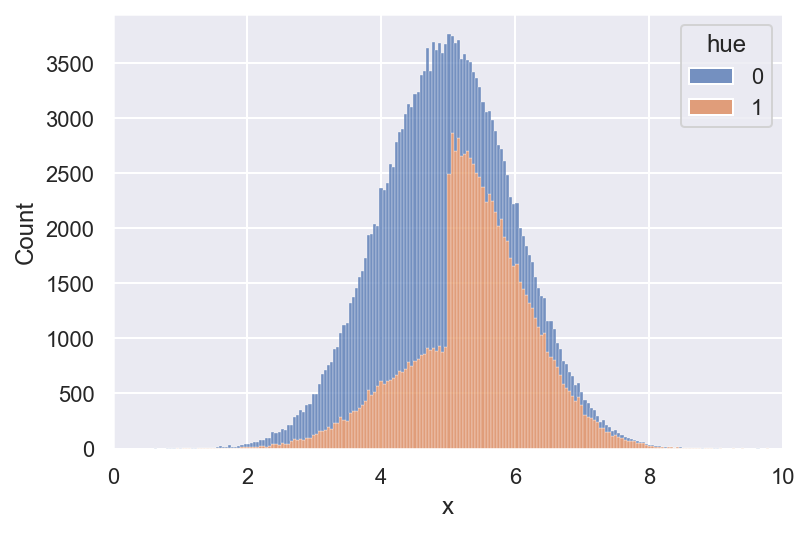

In [503]:
size = 100000

control = np.random.binomial(1, 0.25, size)
test = np.random.binomial(1, 0.75, size)
Y = np.append(control, test)

x_sample = sorted(np.random.normal(5, 1, size*2))
X = x_sample
data = pd.DataFrame({'x':X, 'hue':Y})

(
    sns.histplot(data = data.query('x < 10'), x = 'x', hue = 'hue', multiple='stack')
    .set(xlim = (0, 10))
)

In [464]:
def get_results_for_continious_factor_normal_2(p1, p2, size=10000):
    control = np.random.binomial(1, p1, int(size*1.5))
    test = np.random.binomial(1, p2, int(size/2))
    Y = np.concatenate((control, test))
    
    x_sample = sorted(np.random.normal(0, 1, size*2))
    X = np.array(x_sample)
    X = add_constant(X)
    
    lin = OLS(Y, X).fit()
    log = Logit(Y, X).fit()

    print('____________________________________linreg____________________________________')
    print(lin.summary().tables[1])
    print('\n')
    print('____________________________________logreg____________________________________')
    print(log.summary().tables[1])
    
    print('lin_pvalue = ' + str(lin.pvalues[1]) + ', log_pvalue = ' + str(log.pvalues[1]))
    print('LIN' if lin.pvalues[1] < log.pvalues[1] else 'LOG')
    return 'LIN' if lin.pvalues[1] < log.pvalues[1] else 'LOG'

In [500]:
get_results_for_continious_factor_normal_2(0.65, 0.6, size = 1000)

Optimization terminated successfully.
         Current function value: 0.655254
         Iterations 4
____________________________________linreg____________________________________
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6366      0.011     59.162      0.000       0.616       0.658
x1            -0.0084      0.011     -0.777      0.437      -0.029       0.013


____________________________________logreg____________________________________
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5609      0.047     12.061      0.000       0.470       0.652
x1            -0.0361      0.046     -0.777      0.437      -0.127       0.055
lin_pvalue = 0.4373278711486577, log_pvalue = 0.4371422876781357
LOG


'LOG'

## Выводы

**Просимулировал линрег/логрег с непрерывным фактором, вместо бинарного**

**Суть**: разница в пвалью появляется, если подставить распредление Фишера

Про разницу:
- Во первых, в случае с бинарным факторов пвалью не одинаковые, они начинают различаться на 5й-6й знак после запятой
    - линрег только в 25% случаях имел более низкий пвалью (это я к тому, что различие вряд ли случайны и вызваны округлениями пайтона внутренними к примеру)

- при переходе с бинарного фактора на непрерывный с нормальным распределением, pvalue у линрега и логрега практическине различаются (5й-6й знак только)
- при переходе с бинарного фактора на непрерывный с распределением фишера, pvalue у линрега и логрега сильно различаются
    - при этом логрег чувствительнее (приложил фотку, на которой прогнал в цикле две модели и посчитал, сколько в среднем та или иная модель обнаруживала различия)

Почему тут такое различие в зависимости от вида распределения, я не очень пока понял

Кстати распределение Фишера это просто частный случай распределения Вэйбулла